In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from scripts.lmfit_model import division_model, sum_model

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error, root_mean_squared_error


def nse(predictions, targets):
    return 1 - (
        np.nansum((targets - predictions) ** 2) / np.nansum((targets - np.nanmean(targets)) ** 2)
    )


def kge(predictions, targets):
    sim_mean = np.mean(targets, axis=0)
    obs_mean = np.mean(predictions)

    r_num = np.sum((targets - sim_mean) * (predictions - obs_mean), axis=0)
    r_den = np.sqrt(
        np.sum((targets - sim_mean) ** 2, axis=0)
        * np.sum(
            (predictions - obs_mean) ** 2,
        )
    )
    if r_den == 0:
        r = np.nan
    else:
        r = r_num / r_den
    # calculate error in spread of flow alpha
    if np.std(predictions) == 0:
        alpha = np.nan
    else:
        alpha = np.std(targets, axis=0) / np.std(predictions)
    # calculate error in volume beta (bias of mean discharge)
    if np.sum(predictions) == 0:
        beta = np.nan
    else:
        beta = np.sum(targets, axis=0) / np.sum(predictions)
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return kge_, r, alpha, beta


def rmse(predictions, targets):
    return mean_squared_error(targets, predictions, squared=False)


def relative_error(predictions, targets):
    return np.mean(((targets - predictions) / targets) * 100)


def metric_df(gauge_id, predictions, targets):
    res_df = pd.DataFrame()

    res_df.loc[gauge_id, "NSE"] = nse(predictions, targets)

    res_df.loc[gauge_id, ["KGE", "r", "alpha", "beta"]] = kge(predictions, targets)

    if any(np.isnan(predictions)) | any(np.isnan(targets)):
        res_df.loc[gauge_id, "RMSE"] = np.nan
    else:
        res_df.loc[gauge_id, "RMSE"] = root_mean_squared_error(predictions, targets)

    res_df.loc[gauge_id, "delta"] = relative_error(predictions, targets)

    return res_df


### Load data on most high level flood predictions

In [21]:
import json

with open("configs/min_lvls.json") as f:
    min_lvls = json.load(f)

obj = pd.read_pickle(
    "/home/dmbrmv/DevWSL/Skoltech/california_floods/LstmResults/California_cudalstm_lvl_256_365_3108_220353/test/model_epoch013/test_results.p"
)
file_df = dict()
metric_res = dict()
max_lvls = dict()
for gauge in obj.keys():
    file = obj[gauge]["1D"]["xr"].to_dataframe().droplevel(1)
    metric_res[gauge] = metric_df(gauge_id=gauge, predictions=file["lvl_sim"], targets=file["lvl_obs"])
    file_df[gauge] = file
    max_lvls[gauge] = pd.concat([file[["lvl_sim"]].max(), file[["lvl_obs"]].max()])
metric_res = pd.concat(metric_res.values())
metric_res["RMSE"].median()


/home/dmbrmv/venvs/geo/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_96764/2456498572.py:7: RuntimeWarning: Mean of empty slice
  np.nansum((targets - predictions) ** 2) / np.nansum((targets - np.nanmean(targets)) ** 2)
/tmp/ipykernel_96764/2456498572.py:7: RuntimeWarning: invalid value encountered in scalar divide
  np.nansum((targets - predictions) ** 2) / np.nansum((targets - np.nanmean(targets)) ** 2)
/home/dmbrmv/venvs/geo/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_96764/2456498572.py:7: RuntimeWarning: Mean of empty slice
  np.nansum((targets - predictions) ** 2) / np.nansum((targets - np.nanmean(targets)) ** 2)
/tmp/ipykernel_96764/2456498572.py:7: RuntimeWarning: invalid value encountered in scalar

0.4698520302772522

In [22]:
cool_gauges = list()

for gauge_id, max_lvl in max_lvls.items():
    # if max_lvl["lvl_sim"] + min_lvls[f"{gauge_id}"] > 3:
    cool_gauges.append(gauge_id)
# cool_gauges.append("11152050")
# cool_gauges.append("11152650")
# for gauge_id in cool_gauges:
#     (file_df[f"{gauge_id}"]).plot(title=f"{gauge_id}")
cool_gauges


['11143200', '11152500', '11152650', '11159200', '1117777']

In [23]:
import random
from pathlib import Path

era_input = ["prcp_e5l", "t_max_e5l", "t_min_e5l", "t_mean_e5l"]
# discharge or lvl
hydro_target = "lvl"
static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]
ws_file = gpd.read_file(
    filename="/home/dmbrmv/DevWSL/Skoltech/california_floods/WsArea/res/california/res/gauge_points_ws.gpkg"
)
ws_file = ws_file.set_index("gauge_id")
# time series directory
ts_dir = Path("/home/dmbrmv/DevWSL/Skoltech/california_floods/DataLSTM/time_series")
ts_dir.mkdir(exist_ok=True, parents=True)
# define variables require to perform hindcast
gauges = [i.stem for i in Path(f"{ts_dir}").glob("*.nc")]
ws_file = ws_file.loc[ws_file.index.isin(gauges), :]
random.shuffle(gauges)
gauge_size = len(gauges)


In [24]:
if "point_geom" not in ws_file:
    point_df = gpd.read_file("data/gauge_points.gpkg")
    point_df = point_df.rename(columns={"Unnamed: 0": "gauge_id"})
    if "gauge_id" in point_df.columns:
        point_df = point_df.set_index("gauge_id")
    point_df["point_geom"] = point_df["geometry"]
    ws_file = ws_file.join(point_df["point_geom"])
if isinstance(ws_file["point_geom"].values[0], str):
    ws_file["point_geom"] = gpd.GeoSeries.from_wkt(ws_file["point_geom"])


### Get Q(H) curve for desired gauge_id

In [25]:
bad_visual = list(
    i.replace('"', "").replace(" ", "") for i in pd.read_csv("configs/bad_gauges.csv").columns
)
prepared_params = list(i.stem for i in Path("ConvertedQH/FitParams/").glob("*.json"))
param_gauges = [i.split("_") for i in prepared_params if i.split("_")[0] not in bad_visual]
param_gauges = [i for i in param_gauges if i[0] in cool_gauges]

In [30]:
def draw_qh(param_gauges, ws_file):
    gauge_id, model_type = param_gauges
    try:
        table_discharge = pd.read_csv(
            f"ConvertedQH/Discharge/{gauge_id}.csv",
            index_col="date",
            parse_dates=True,
            dtype={"gauge_id": str, "discharge": float},
        )
    except FileNotFoundError:
        return
    qh_table = pd.read_csv(
        f"ConvertedQH/DischargeLvL/{gauge_id}.csv",
        index_col="date",
        parse_dates=True,
        dtype={"gauge_id": str, "q_cms": float, "lvl_m": float},
    )
    qh_table = qh_table.sort_values("q_cms", ascending=False)
    y = qh_table["lvl_m"].to_numpy()
    x = qh_table["q_cms"].to_numpy()
    if model_type == "sum":
        pars = sum_model.make_params(
            power={"min": 0.001, "value": 0.1},
            c={"value": 0},
            slope={"value": 1, "min": 0},
            b={"value": 0},
        )
        try:
            result = sum_model.fit(y, pars, x=x)
        except TypeError:
            pass

    elif model_type == "div":
        pars = division_model.make_params(
            power={"min": 0.001, "value": 0.1},
            c={"value": 0},
            slope={"value": 1, "min": 0},
            b={"value": 0},
        )
        if y.size > 0:
            pass
        try:
            result = division_model.fit(y, pars, x=x)
        except TypeError:
            pass
    with open(f"ConvertedQH/FitParams/{gauge_id}_{model_type}.json", "r") as f:
        params = result.params.load(f)

    table_discharge["lvl"] = [
        result.eval(x=i, params=params) for i in table_discharge["discharge"].to_numpy()
    ]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].plot(x, y, "*", label="Field measurements", color="green")
    ax[0].plot(x, result.best_fit, "-", label="Fitted Q(h) curve", linewidth=3)
    ax[0].plot(
        table_discharge.loc["2000":, "discharge"],
        table_discharge.loc["2000":, "lvl"],
        "*",
        label="Q(h) for test period",
        color="red",
    )
    ax[0].set_xlabel("Discharge, cubic meters per second")
    ax[0].set_ylabel("Level, m")
    ax[0].legend()
    ax[0].set_title("Discharge - Level relationship")

    file = file_df[gauge_id]
    file = file.rename(columns={"lvl_obs": "Observations", "lvl_sim": "Predictions"})

    lstm_res = file.plot(ax=ax[1])

    lstm_res.set_xlabel("Date")
    lstm_res.set_ylabel("Level, m")
    lstm_rmse = root_mean_squared_error(y_true=file["Observations"], y_pred=file["Predictions"])
    lstm_res.set_title(f"Prediction RMSE = {lstm_rmse:.2f}")

    fig.suptitle(
        f"Gauge {gauge_id} - {ws_file.loc[gauge_id, 'name']},\n Watershed Area - {ws_file.loc[gauge_id, 'new_area']:.0f} sq. km"
    )
    plt.tight_layout()
    plt.savefig(f"Res/Images/{gauge_id}.png", dpi=300, bbox_inches="tight")

    return None


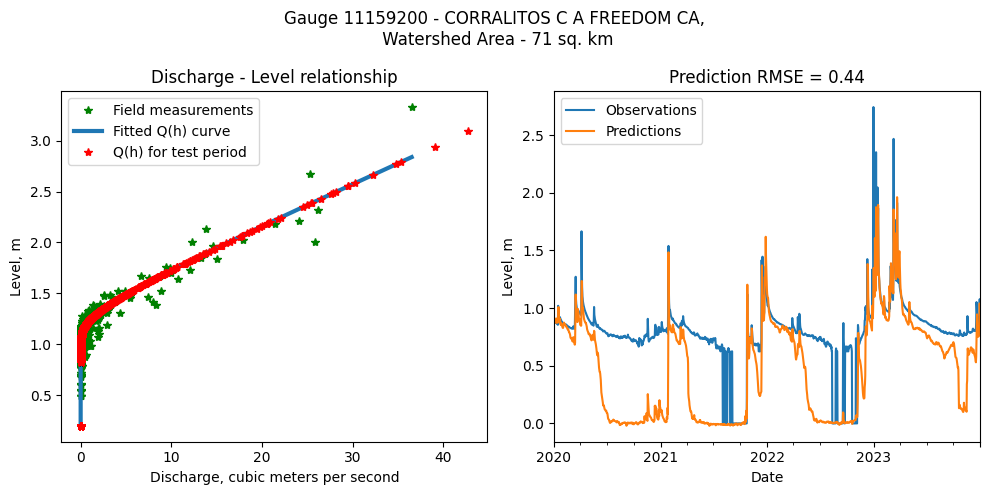

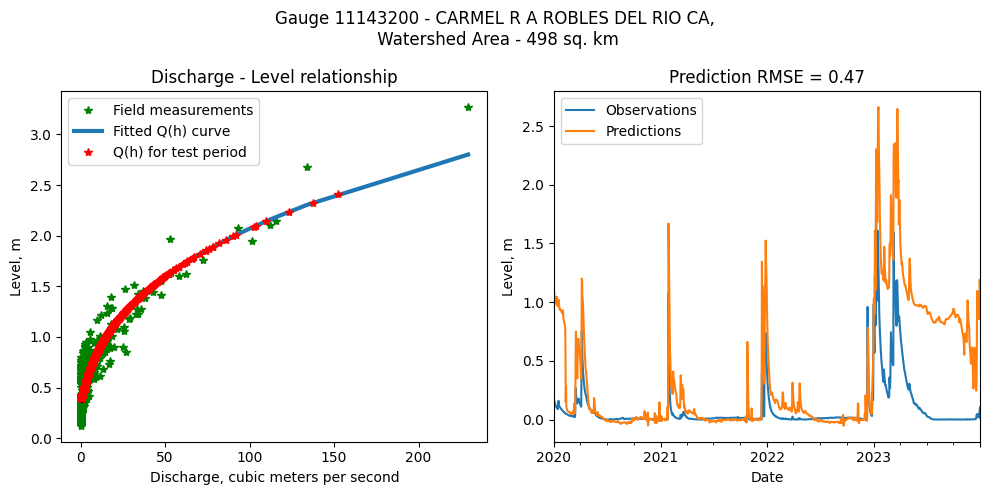

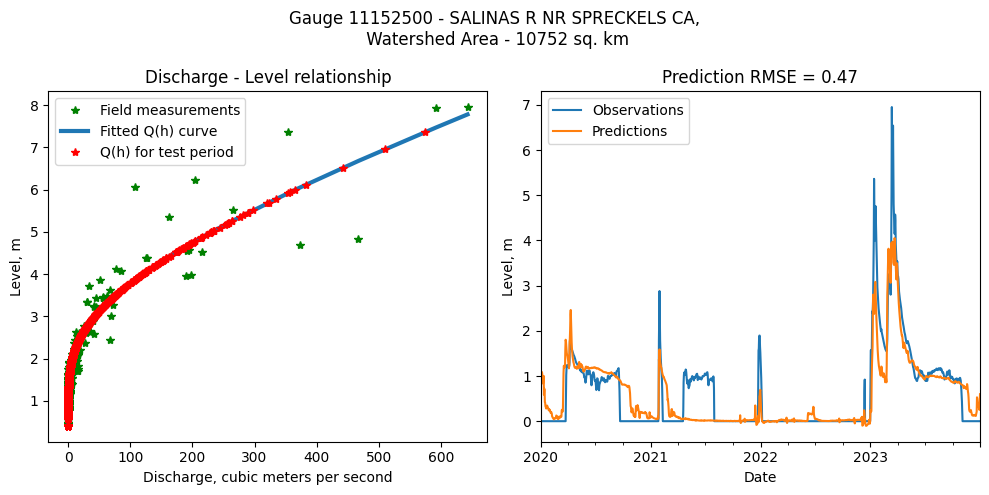

In [31]:
for param_pair in param_gauges:
    _ = draw_qh(param_gauges=param_pair, ws_file=ws_file)


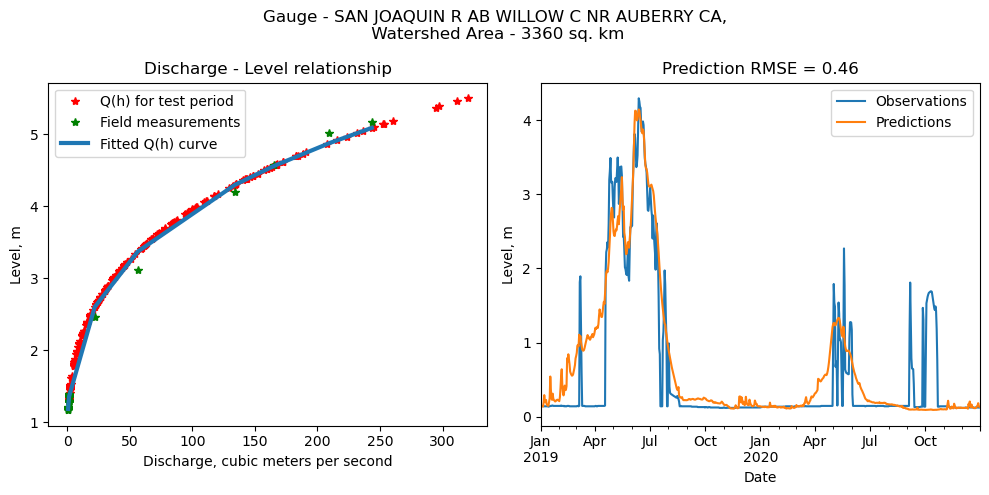

In [109]:
gauge_id, model_type = param_gauges[0]

table_discharge = pd.read_csv(
    f"ConvertedQH/Discharge/{gauge_id}.csv",
    index_col="date",
    parse_dates=True,
    dtype={"gauge_id": str, "discharge": float},
)

qh_table = pd.read_csv(
    f"ConvertedQH/DischargeLvL/{gauge_id}.csv",
    index_col="date",
    parse_dates=True,
    dtype={"gauge_id": str, "q_cms": float, "lvl_m": float},
)
qh_table = qh_table.sort_values("q_cms", ascending=False)
y = qh_table["lvl_m"].to_numpy()
x = qh_table["q_cms"].to_numpy()
if model_type == "sum":
    pars = sum_model.make_params(
        power={"min": 0.001, "value": 0.1},
        c={"value": 0},
        slope={"value": 1, "min": 0},
        b={"value": 0},
    )
    try:
        result = sum_model.fit(y, pars, x=x)
    except TypeError:
        pass

elif model_type == "div":
    pars = division_model.make_params(
        power={"min": 0.001, "value": 0.1},
        c={"value": 0},
        slope={"value": 1, "min": 0},
        b={"value": 0},
    )
    if y.size > 0:
        pass
    try:
        result = division_model.fit(y, pars, x=x)
    except TypeError:
        pass
with open(f"ConvertedQH/FitParams/{gauge_id}_{model_type}.json", "r") as f:
    params = result.params.load(f)

table_discharge["lvl"] = [
    result.eval(x=i, params=params) for i in table_discharge["discharge"].to_numpy()
]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(
    table_discharge.loc["2019":, "discharge"],
    table_discharge.loc["2019":, "lvl"],
    "*",
    label="Q(h) for test period",
    color="red",
)
ax[0].plot(x, y, "*", label="Field measurements", color="green")
ax[0].plot(x, result.best_fit, "-", label="Fitted Q(h) curve", linewidth=3)
ax[0].set_xlabel("Discharge, cubic meters per second")
ax[0].set_ylabel("Level, m")
ax[0].legend()
ax[0].set_title("Discharge - Level relationship")

file = file_df[gauge_id]
file = file.rename(columns={"lvl_obs": "Observations", "lvl_sim": "Predictions"})

root_mean_squared_error(y_true=file["Observations"], y_pred=file["Predictions"])

lstm_res = file.plot(ax=ax[1])

lstm_res.set_xlabel("Date")
lstm_res.set_ylabel("Level, m")
lstm_rmse = root_mean_squared_error(y_true=file["Observations"], y_pred=file["Predictions"])
lstm_res.set_title(f"Prediction RMSE = {lstm_rmse:.2f}")


fig.suptitle(
    f"Gauge - {ws_file.loc[gauge_id, 'name']},\n Watershed Area - {ws_file.loc[gauge_id, 'new_area']:.0f} sq. km"
)
plt.tight_layout()
plt.savefig(f"Res/Images/{gauge_id}.png", dpi=300, bbox_inches="tight")

In [ ]:
plt.plot(
    file.loc["2019":, "discharge"],
    table_discharge.loc["2019":, "lvl"],
    "*",
    label="Q(h) for test period",
    color="red",
)
plt.plot(x, y, "*", label="Field measurements", color="green")
plt.plot(x, result.best_fit, "-", label="Fitted Q(h) curve", linewidth=3)
plt.set_xlabel("Discharge, cubic meters per second")
plt.set_ylabel("Level, m")
plt.legend()
plt.set_title("Discharge - Level relationship")


In [83]:
ax[0].plot(x, y, "*", label="Field measurements", color="green")
ax[0].plot(x, result.best_fit, "-", label="Fitted Q(h) curve", linewidth=3)
ax[0].set_xlabel("Discharge, cubic meters per second")
ax[0].set_ylabel("Level, m")
ax[0].legend()
ax[0].set_title("Discharge - Level relationship")


0.46063903

,lvl_obs,lvl_sim
date,,
2019-01-01,0.146080,0.140105
2019-01-02,0.146080,0.143528
2019-01-03,0.146080,0.138847
2019-01-04,0.146080,0.138629
2019-01-05,0.140895,0.138584
...,...,...
2020-12-27,0.124971,0.149474
2020-12-28,0.130342,0.183340
2020-12-29,0.124971,0.144896


In [ ]:
for desc in tqdm(param_gauges):
    gauge_id, model_type = desc
    try:
        table_discharge = pd.read_csv(
            f"ConvertedQH/Discharge/{gauge_id}.csv",
            index_col="date",
            parse_dates=True,
            dtype={"gauge_id": str, "discharge": float},
        )

        qh_table = pd.read_csv(
            f"ConvertedQH/DischargeLvL/{gauge_id}.csv",
            index_col="date",
            parse_dates=True,
            dtype={"gauge_id": str, "q_cms": float, "lvl_m": float},
        )
        y = qh_table["lvl_m"].to_numpy()
        x = qh_table["q_cms"].to_numpy()
        if model_type == "sum":
            pars = sum_model.make_params(
                power={"min": 0.001, "value": 0.1},
                c={"value": 0},
                slope={"value": 1, "min": 0},
                b={"value": 0},
            )
            try:
                result = sum_model.fit(y, pars, x=x)
            except TypeError:
                continue

        elif model_type == "div":
            pars = division_model.make_params(
                power={"min": 0.001, "value": 0.1},
                c={"value": 0},
                slope={"value": 1, "min": 0},
                b={"value": 0},
            )
            if y.size > 0:
                continue
            try:
                result = division_model.fit(y, pars, x=x)
            except TypeError:
                continue

        with open(f"ConvertedQH/FitParams/{gauge_id}_{model_type}.json", "r") as f:
            params = result.params.load(f)

        table_discharge["lvl"] = [
            result.eval(x=i, params=params) for i in table_discharge["discharge"].to_numpy()
        ]
        table_discharge.to_csv(f"ConvertedQH/ResultQH/{gauge_id}.csv")
        plt.plot(x, y, "*", label="field", color="green")
        plt.plot(
            table_discharge["discharge"], table_discharge["lvl"], "*", label="predictions", color="red"
        )
        plt.legend()
        plt.savefig(f"ConvertedQH/ImagesQH/{gauge_id}.png")
        plt.close()
    except FileNotFoundError:
        continue


### Get Obs, Sim plot for desired gauge_id

In [ ]:
for gauge_id in cool_gauges:
    (file_df[f"{gauge_id}"] + min_lvls[f"{gauge_id}"]).plot()
    plt.show()


In [ ]:
for gauge_id, pred_df in file_df.items():
    file = pred_df.loc[:, ["lvl_sim"]]
    file = file.rename(columns={"lvl_sim": "lvl"})
    file.to_csv(f"{tmp_pred}/{gauge_id}.csv")

for gauge_id in list(i.stem for i in Path("ConvertedQH/ResultQH/").glob("*.csv")):
    read_lvl_csv(f"ConvertedQH/ResultQH/{gauge_id}.csv").loc[:"2018", ["lvl"]].to_csv(
        f"{archive_lvls}/{gauge_id}.csv"
    )
